In [ ]:
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

from scipy.spatial import Voronoi, voronoi_plot_2d, ConvexHull

from tqdm.auto import tqdm
from celluloid import Camera

In [ ]:
tau = 2 * np.pi
plt.style.use("dark_background")

In [ ]:
import dataclasses

@dataclasses.dataclass
class CustomVoronoi:
  points: np.ndarray
  vertices: np.ndarray
  ridge_points: np.ndarray
  ridge_vertices: list[list[int]]
  furthest_site: bool = False

In [ ]:
def save_anim(camera, fpath, fps=30):
  anim = camera.animate()
  fname, ext = os.path.splitext(fpath)

  if ext == '.gif':
    anim.save(fpath, writer=animation.PillowWriter(fps=fps))
  elif ext == '.mp4':
    # For colab.
    FFwriter = animation.FFMpegWriter(fps=fps)
    anim.save(fpath, writer=FFwriter)
  else:
    raise ValueError(f'Unknown file extension `{ext}`')

### Diffusion Limited Aggregation

In [ ]:
np.random.seed(0)

n_points = 200
point_size = 20**(3-np.log10(n_points))
vel_step = 0.25
box_size = np.array([160, 90])
points = box_size * np.random.rand(n_points, 2)
angles = np.exp(1j * tau * np.random.rand(n_points))
# Normalize the velocities so that all points have the same velocity.
velocities = vel_step * (np.column_stack([angles.real, angles.imag]))
mask_alive = np.ones(len(points), dtype=bool)

points[0] = box_size / 2
mask_alive[0] = 0
alive_points, dead_points = points[mask_alive], points[~mask_alive]

# fig, axs = plt.subplots(figsize=(16,9))
# plt.scatter(alive_points[:,0], alive_points[:,1], c='r', s=point_size)
# plt.scatter(dead_points[:,0], dead_points[:,1], c='b', s=point_size)
# plt.axis('equal')
# plt.xlim(0,box_size[0])
# plt.ylim(0,box_size[1])
# plt.axis('off')
# plt.show()

  0%|          | 0/197 [00:00<?, ?it/s]

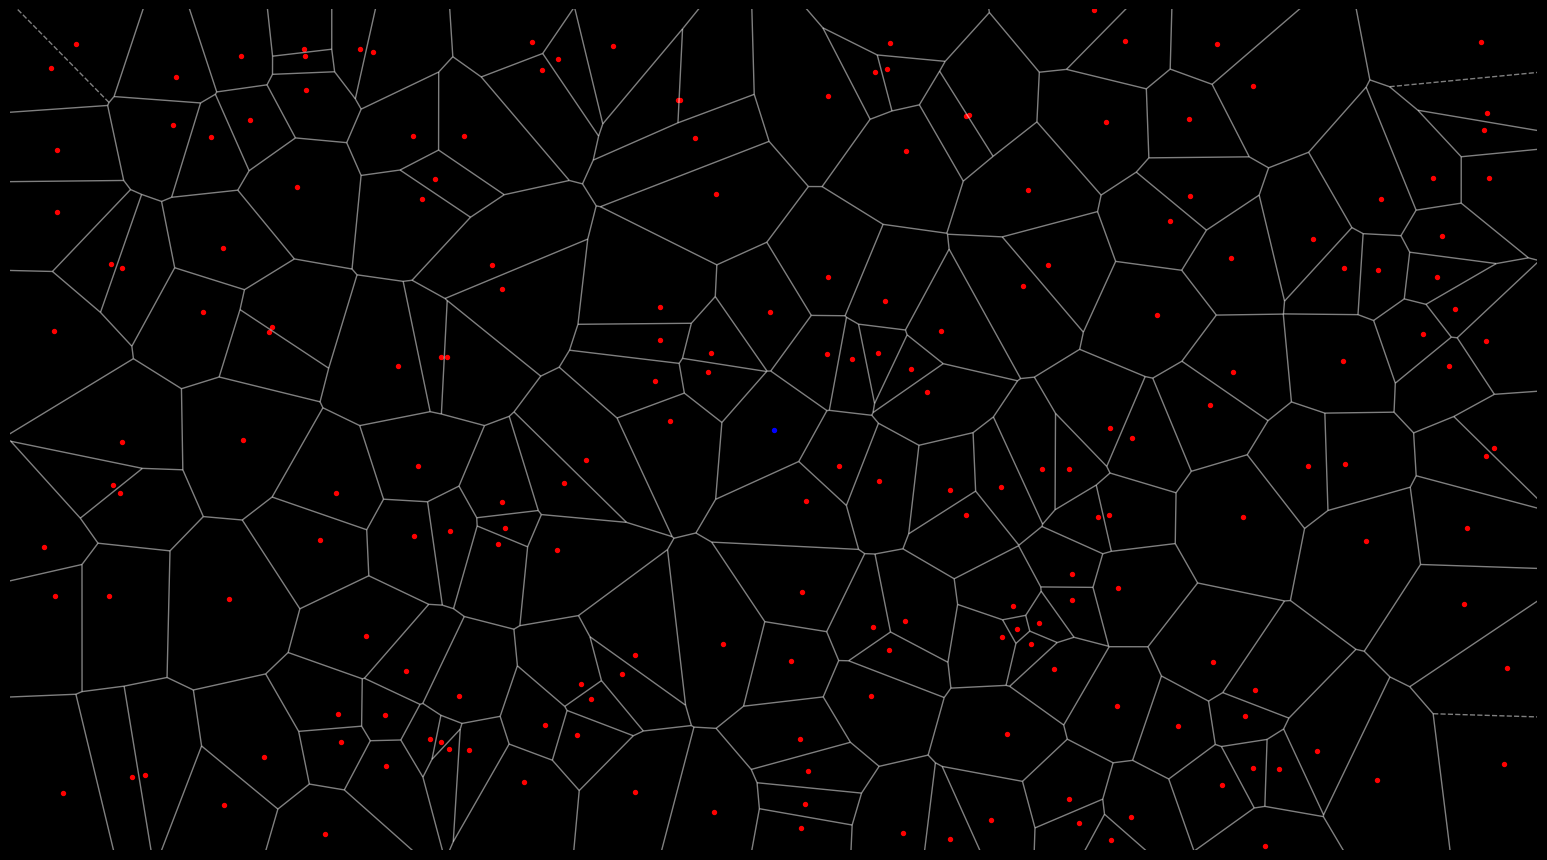

In [ ]:
fig, axs = plt.subplots(figsize=(16,9))
plt.tight_layout()
plt.axis('equal')
plt.axis('off')
camera = Camera(fig)

for p in tqdm(range(2, len(alive_points))):
  vor = Voronoi(np.vstack((alive_points[:p], dead_points)))
  voronoi_plot_2d(vor, ax=fig.gca(), show_points=False, show_vertices=False, line_colors='w', line_alpha=0.5)
  plt.scatter(alive_points[:p,0], alive_points[:p,1], c='r', s=point_size)
  plt.scatter(dead_points[0,0], dead_points[0,1], c='b', s=point_size)
  plt.xlim(0,box_size[0]);  plt.ylim(0,box_size[1])
  camera.snap()

save_anim(camera, 'vor_growth.mp4', fps=1)

In [ ]:
wiggle_room = 50
time_step = 0
save_every = 1000
death_proximity = 0.3 * np.log(point_size)


vid_index = 0
while True:
  fig, axs = plt.subplots(figsize=(16,9))
  plt.tight_layout()
  plt.axis('equal')
  plt.axis('off')
  camera = Camera(fig)

  for time_step in tqdm(range(save_every), leave=False):
    if time_step%wiggle_room == wiggle_room-1:  # Change angle by 10%.
      # angles *= np.exp(0.1j * tau * np.random.rand(n_points))
      angles += 0.1 * np.exp(1j * tau * np.random.rand(n_points))
      velocities = vel_step * (np.column_stack([angles.real, angles.imag]))

    alive_points, dead_points = points[mask_alive], points[~mask_alive]

    # Kill points that touch the dead
    dists = scipy.spatial.distance.cdist(alive_points, dead_points)
    mask_kill = dists.min(axis=1) <= death_proximity
    full_mask_kill = np.zeros(len(mask_alive), dtype=bool)
    full_mask_kill[mask_alive] = mask_kill
    mask_alive = mask_alive & ~full_mask_kill

    # Update positions based on velocities.
    points[mask_alive] = (points[mask_alive] + velocities[mask_alive]) % box_size
    alive_points, dead_points = points[mask_alive], points[~mask_alive]
    vor = Voronoi(np.vstack((alive_points, dead_points)))

    # Ignore ridges for dead points.
    new_ridge_points, new_ridge_vertices = [], []
    for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
      if vor.points[pointidx[0]] in alive_points or vor.points[pointidx[1]] in alive_points:
        new_ridge_points.append(pointidx)
        new_ridge_vertices.append(simplex)
    new_ridge_points = np.array(new_ridge_points)
    vor = CustomVoronoi(vor.points, vor.vertices, new_ridge_points, new_ridge_vertices)

    voronoi_plot_2d(vor, ax=fig.gca(), show_points=False, show_vertices=False, line_colors='w', line_alpha=0.5)
    plt.scatter(alive_points[:,0], alive_points[:,1], c='r', s=point_size)
    plt.scatter(dead_points[:,0], dead_points[:,1], c='b', s=point_size)
    plt.xlim(0,box_size[0]);  plt.ylim(0,box_size[1])
    camera.snap()

    ended = len(dead_points) == n_points
    if ended:
      break
  save_anim(camera, f'DLA_{vid_index}.mp4')
  plt.close(fig)
  vid_index += 1
  if ended:
    break

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
save_anim(camera, 'DLA.mp4')

### Gradual fill up

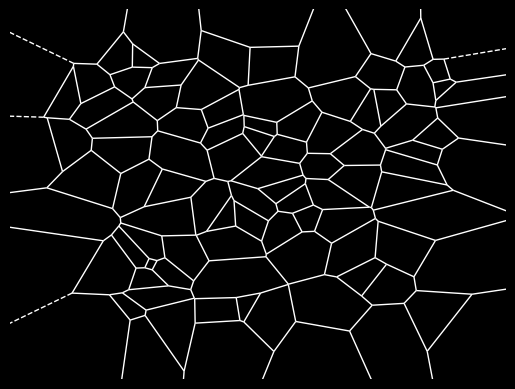

In [ ]:
n_points = 100
vel_step = 0.2
points = 100 * np.random.rand(n_points, 2)
velocities = np.random.rand(n_points, 2)
# Normalize the velocities so that all points have the same velocity.
velocities = vel_step * (velocities / np.linalg.norm(velocities, axis=1)[:, None])

vor = Voronoi(points)

fig = voronoi_plot_2d(vor, show_points=False, show_vertices=False, line_colors='w')
plt.axis('off')
plt.show()

In [ ]:
fig = plt.figure()
plt.axis('off')

wiggle_room = 50
time_steps = 2000

camera = Camera(fig)
for i in tqdm(range(time_steps)):
    if i%wiggle_room == wiggle_room-1:  # Randomize the velocities.
      velocities = np.random.rand(n_points, 2)
      # Normalize the velocities so that all points have the same velocity.
      velocities = vel_step * (velocities / np.linalg.norm(velocities, axis=1)[:, None])
    points = (points + velocities) % 100
    upto = 3 + int(i*(n_points-1)/time_steps)
    display_points = points[:upto]
    vor = Voronoi(display_points)
    fig = voronoi_plot_2d(vor, ax=fig.gca(), show_points=False, show_vertices=False, line_colors='w')
    plt.scatter(display_points[:,0], display_points[:,1], c='b', alpha=0.7)
    plt.scatter(vor.vertices[:,0], vor.vertices[:,1], c='y', alpha=0.7)
    plt.xlim(0,100)
    plt.ylim(0,100)
    camera.snap()

In [ ]:
anim = camera.animate()

FFwriter = animation.FFMpegWriter(fps=30)
# anim.save('voronoi.gif', writer=animation.PillowWriter(fps=10))

# For colab.
anim.save(f'voronoi.mp4', writer=FFwriter)